In [44]:
import numpy as np
from datetime import datetime
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

sns.set_theme(style='whitegrid')
pl.Config.set_tbl_rows(50)
pl.Config.set_tbl_cols(-1)
warnings.filterwarnings('ignore')

In [2]:
df = pl.scan_csv('data/311_Service_Requests_from_2010_to_Present_20231110.csv', ignore_errors=True)

Filter dataset from the year 2019 until present (2023)

In [3]:
df = (
    df.filter(pl.col('Created Date').str.to_datetime(format="%m/%d/%Y %I:%M:%S %p").dt.year() > 2018)
).collect(streaming=True)

Parse date atributes

In [4]:
df = df.with_columns([
    pl.col('Created Date').str.to_datetime(format="%m/%d/%Y %I:%M:%S %p"),
    pl.col('Closed Date').str.to_datetime(format="%m/%d/%Y %I:%M:%S %p"),
    pl.col('Due Date').str.to_datetime(format="%m/%d/%Y %I:%M:%S %p"),
    pl.col('Resolution Action Updated Date').str.to_datetime(format="%m/%d/%Y %I:%M:%S %p"),
    ])

Missing values

In [5]:
null_df = df.null_count().transpose(include_header=True).rename({'column': 'Column', 'column_0': 'Null Count'})

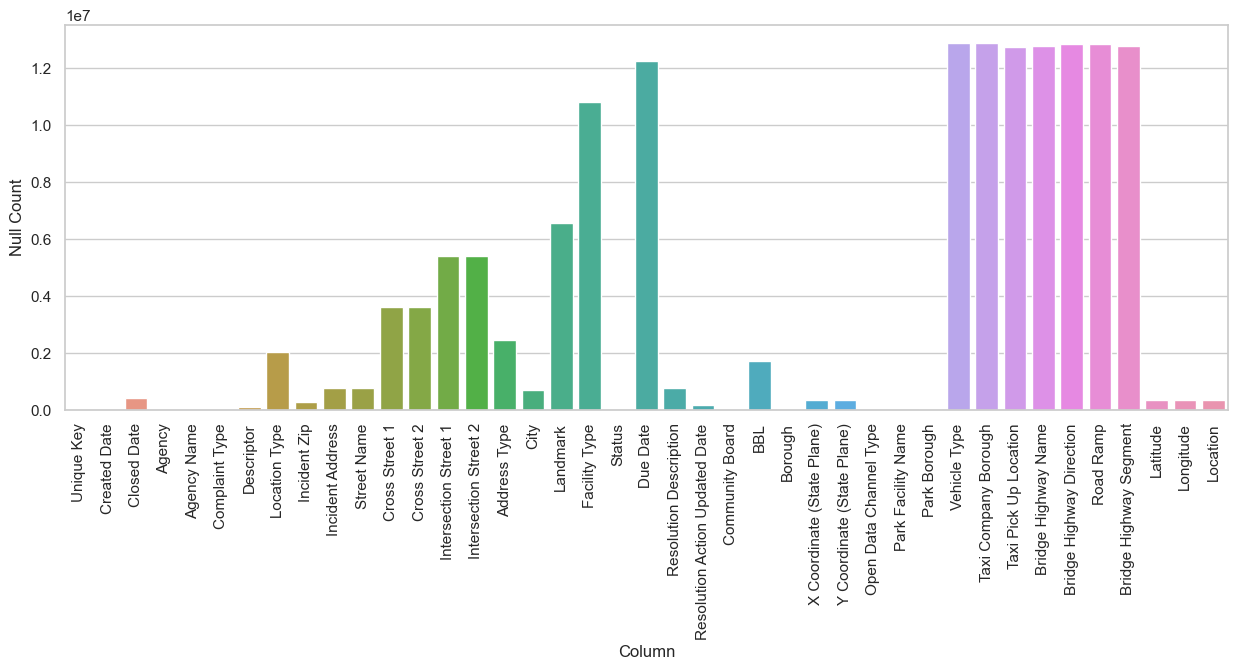

In [24]:
plt.figure(figsize = (15,5))
sns.barplot(data=null_df.to_pandas(), x='Column', y='Null Count')
plt.xticks(rotation=90)
plt.show()

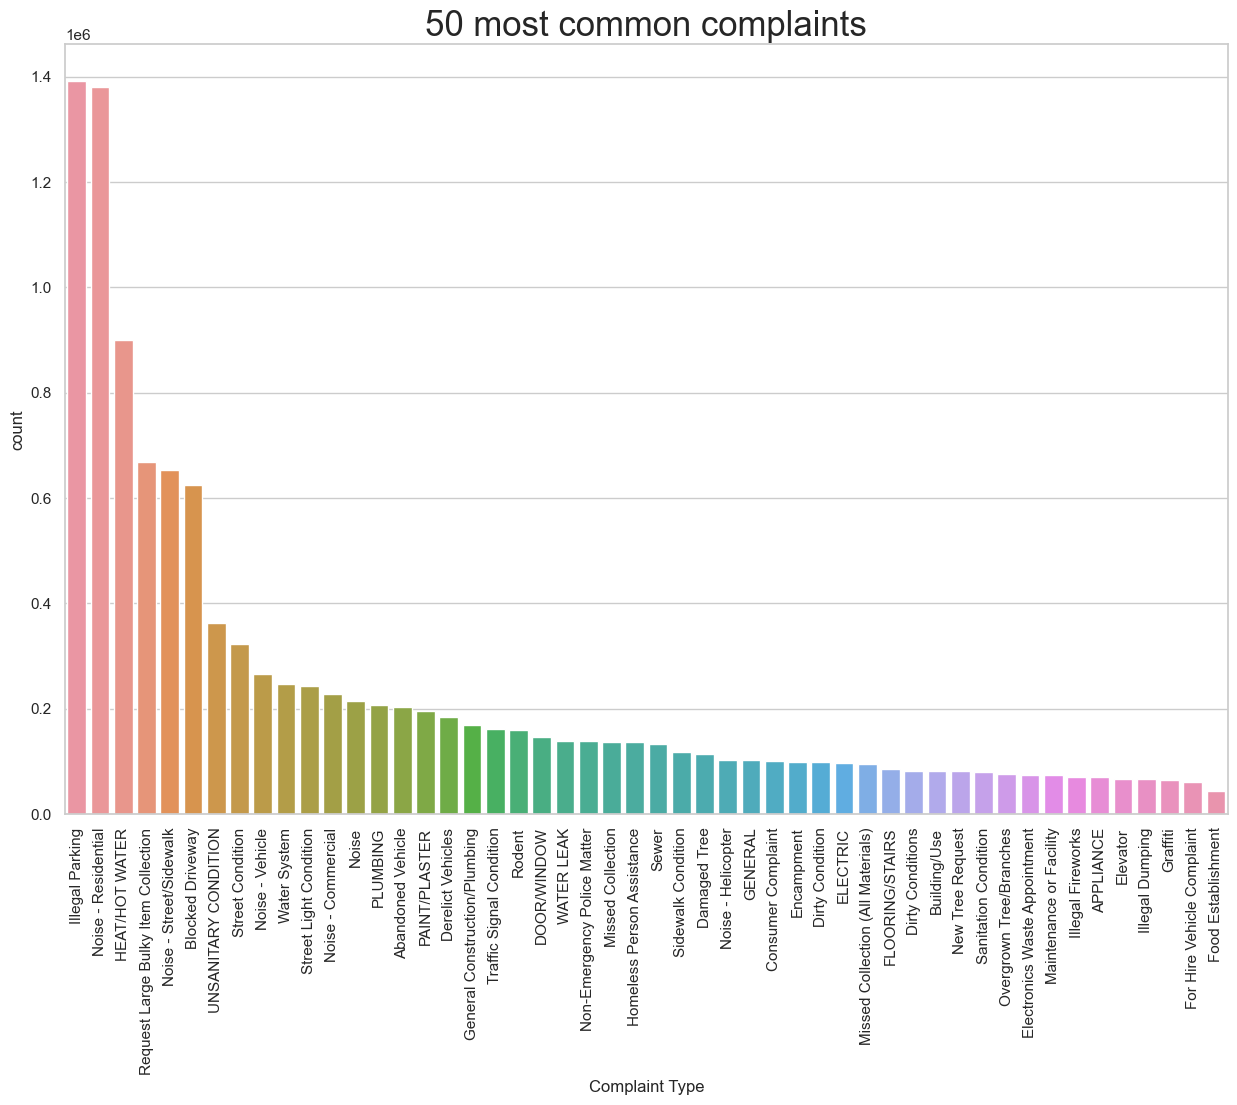

In [25]:
complaints_count = df.group_by('Complaint Type').count().sort('count', descending=True)[:50]
plt.figure(figsize = (15,10))
sns.barplot(data=complaints_count.to_pandas(), x='Complaint Type', y='count')
plt.title('50 most common complaints',fontsize=25)
plt.xticks(rotation=90)
plt.show()

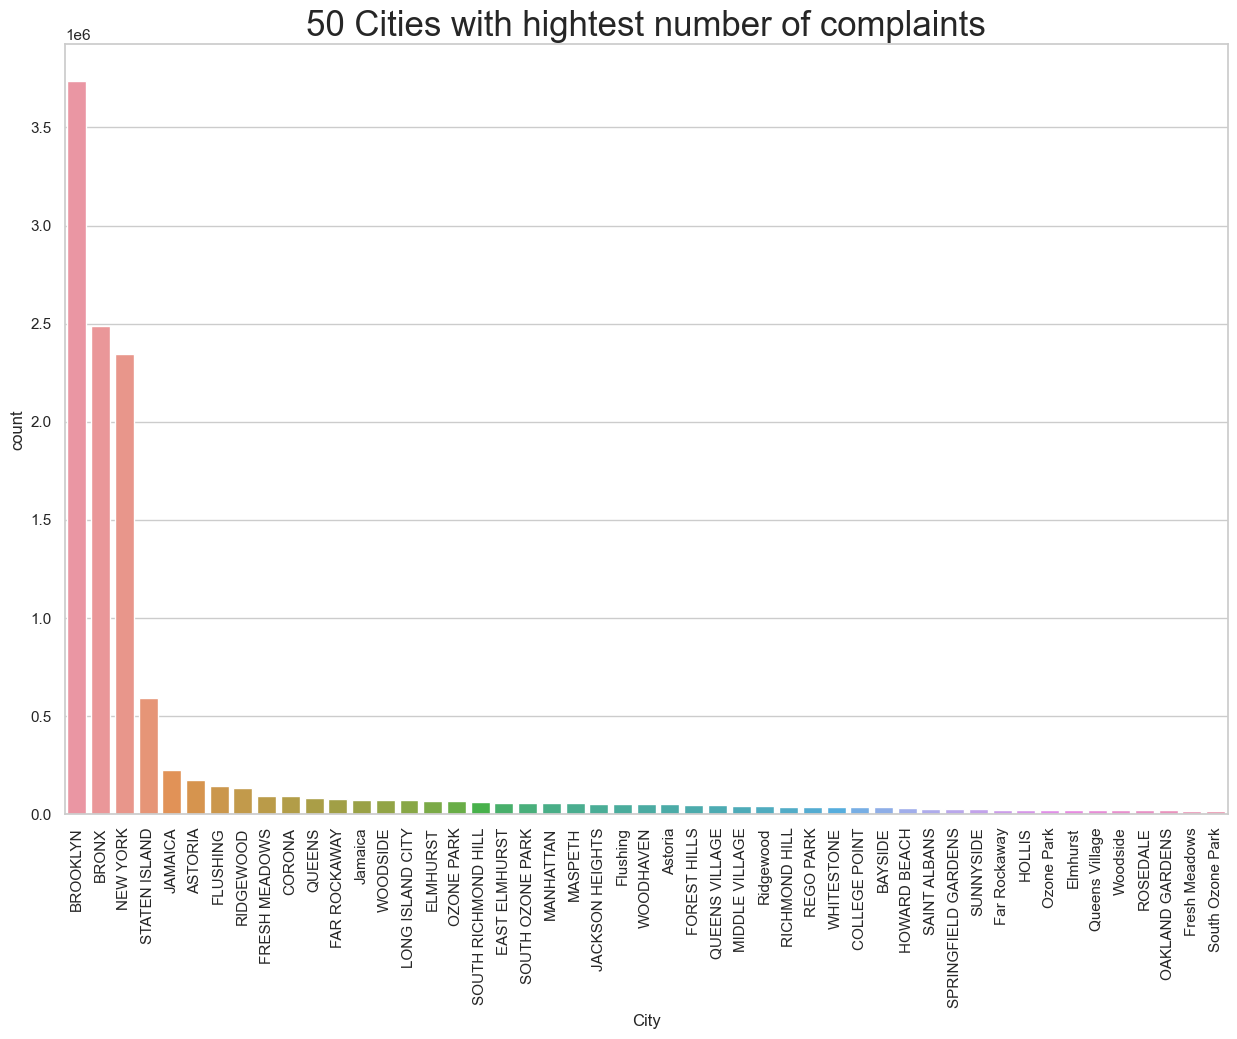

In [26]:
complaints_count = df.group_by('City').count().sort('count', descending=True)[:50]
plt.figure(figsize = (15,10))
sns.barplot(data=complaints_count.to_pandas(), x='City', y='count')
plt.title('50 Cities with hightest number of complaints',fontsize=25)
plt.xticks(rotation=90)
plt.show()

Observed that Brooklyn has the highest number of complaint

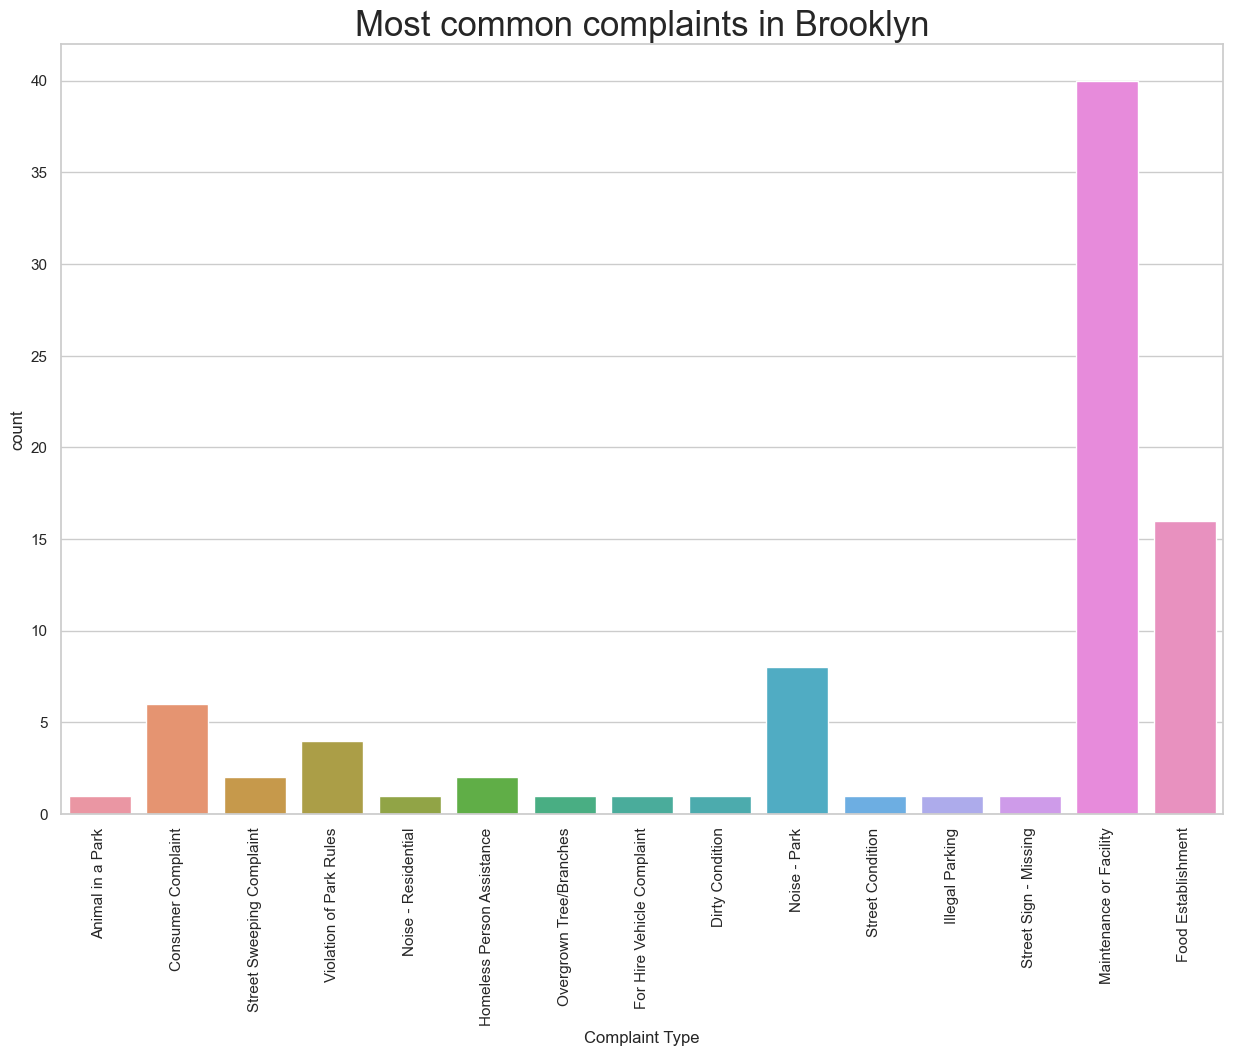

In [27]:
brooklyn_complaint_count = df.filter(pl.col('City') == 'Brooklyn').group_by('Complaint Type').count()
plt.figure(figsize = (15,10))
sns.barplot(data=brooklyn_complaint_count.to_pandas(), x='Complaint Type', y='count')
plt.title('Most common complaints in Brooklyn',fontsize=25)
plt.xticks(rotation=90)
plt.show()

Complaint distridution across Boroughs

In [10]:
# Pie chart of complaints across Boroughs

Air Quality issues across NYC

In [11]:
# Long/lat chart

Average of Response time (#days from an issue's created date to closed date)

10 Complaint Types with slowest response time

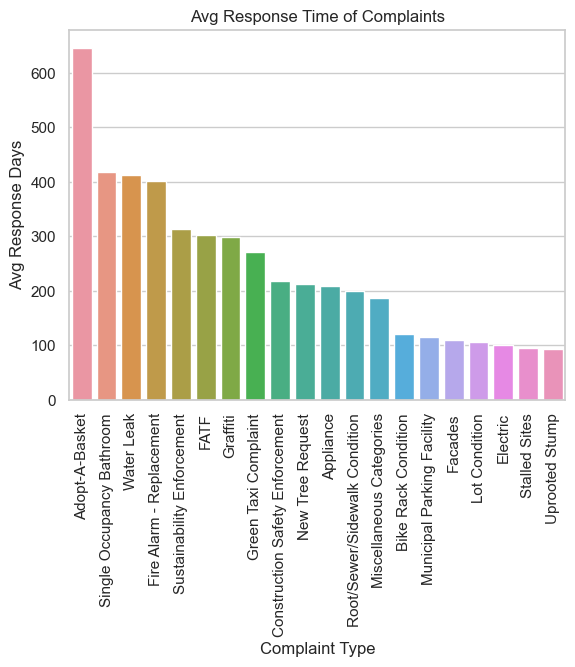

In [21]:
df_temp = df.group_by('Complaint Type').agg((pl.col('Closed Date') - pl.col('Created Date')).dt.days().mean().alias('Avg Response Days')).sort('Avg Response Days', descending=True).head(20)
sns.barplot(data=df_temp.to_pandas(), x='Complaint Type', y='Avg Response Days')
plt.xticks(rotation=90)
plt.title('Avg Response Time of Complaints')
plt.show()

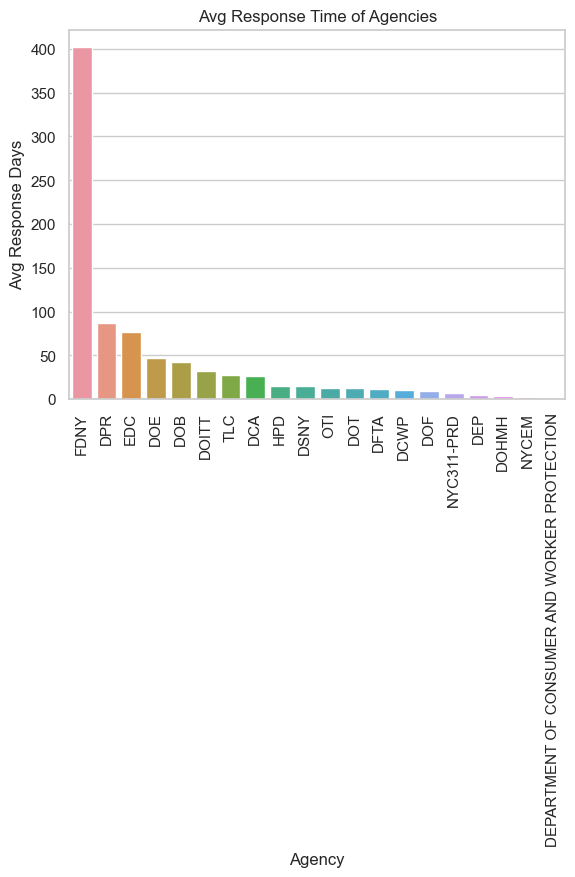

In [22]:
df_temp = df.group_by('Agency').agg((pl.col('Closed Date') - pl.col('Created Date')).dt.days().mean().alias('Avg Response Days')).sort('Avg Response Days', descending=True).head(20)
sns.barplot(data=df_temp.to_pandas(), x='Agency', y='Avg Response Days')
plt.xticks(rotation=90)
plt.title('Avg Response Time of Agencies')
plt.show()

Time Series Analysis on all 5 boroughs

- Predict the volumne of calls on a given day

In [39]:
# Consider only 'Created Date' with over 25 calls; x: Created Date, y: #Calls
time = df['Created Date'].value_counts().filter(pl.col('counts') >= 25).sort('Created Date', descending=False)

In [29]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.api import qqplot
import statsmodels.tsa.api as tsa
import statsmodels.api as sm
from scipy import stats

In [119]:
volume = pd.DataFrame({'ds': time['Created Date'], 'y':time['counts']})
volume['y_orig'] = volume['y'] # to save a copy of the original data.. 
# log-transform y
volume['y'] = np.log(volume['y'])

<AxesSubplot: xlabel='ds'>

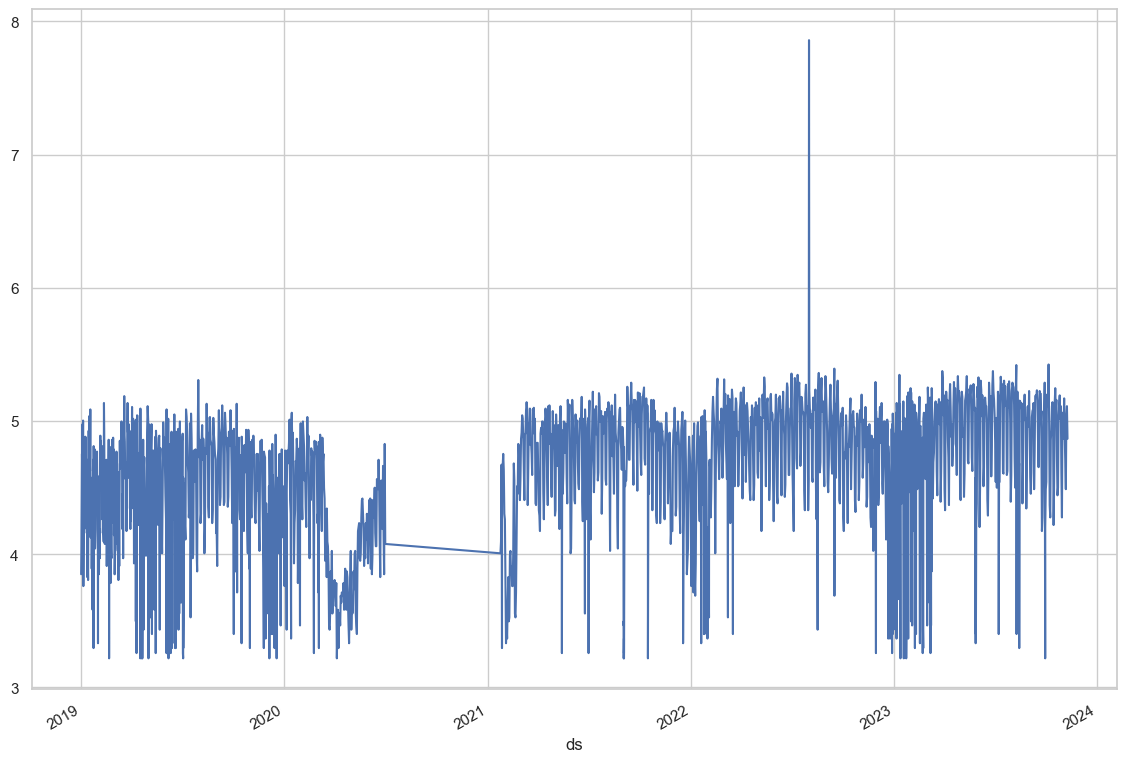

In [120]:
plt.rcParams['figure.figsize']=(14,10)
volume.set_index('ds').y.plot()

In [122]:
from prophet import Prophet 
m = Prophet(yearly_seasonality=True)
m.fit(volume)
future = m.make_future_dataframe(periods=60)
future.tail()
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

16:44:12 - cmdstanpy - INFO - Chain [1] start processing
16:44:12 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
1872,2024-01-03 12:00:00,4.842697,4.461649,5.250516
1873,2024-01-04 12:00:00,4.853316,4.462595,5.221162
1874,2024-01-05 12:00:00,4.801752,4.390307,5.180874
1875,2024-01-06 12:00:00,4.401432,4.024644,4.792598
1876,2024-01-07 12:00:00,4.466044,4.089274,4.859428


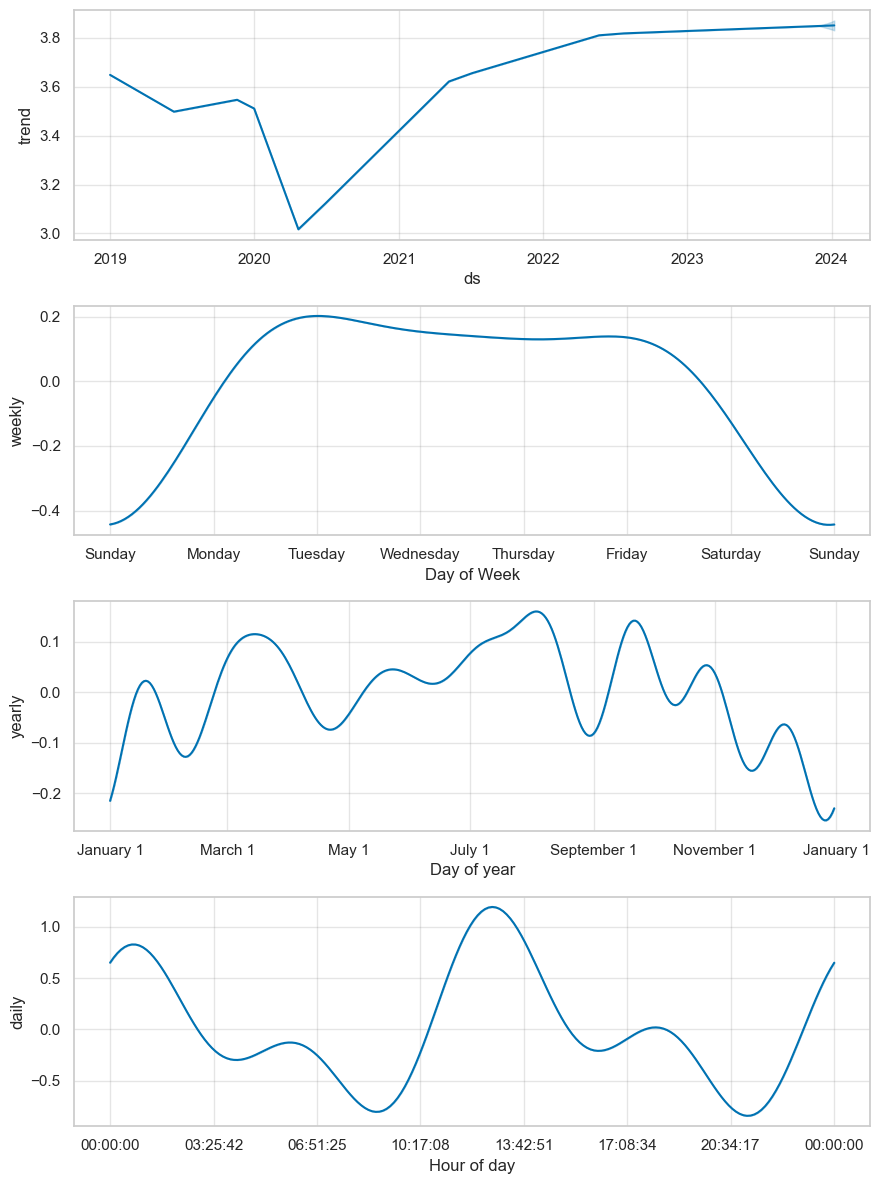

In [123]:
x = m.plot_components(forecast)

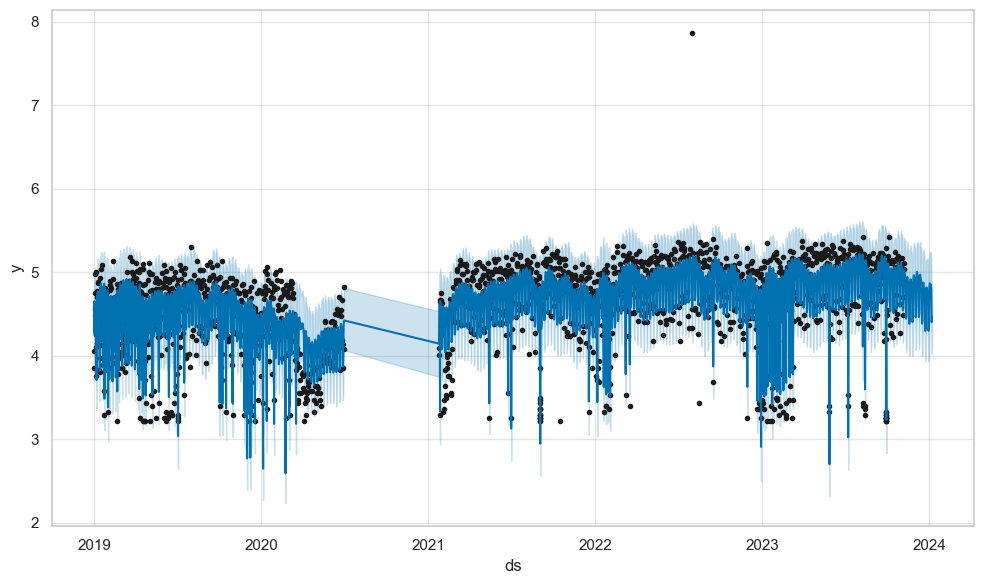

In [124]:
x = m.plot(forecast)

0.6857321851732809


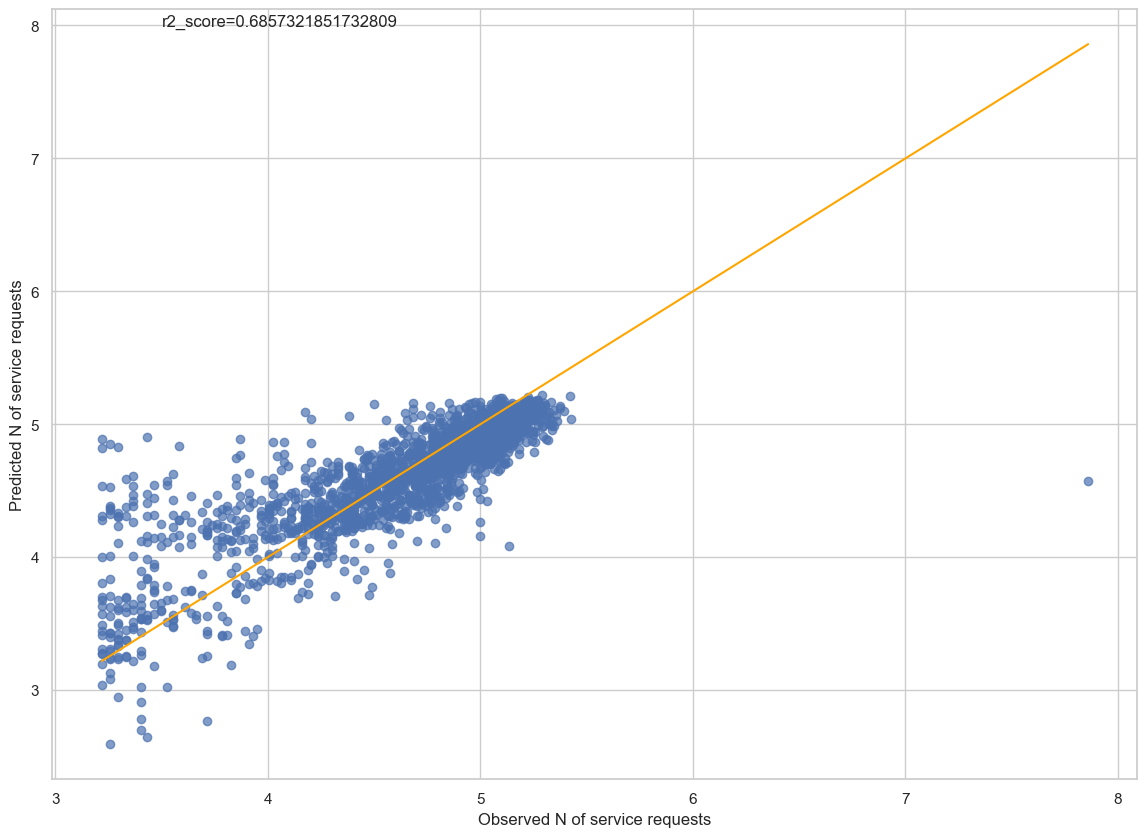

In [125]:
joined_df = volume.merge(forecast, left_on='ds', right_on='ds')
from sklearn.metrics import mean_squared_error, r2_score
plt.scatter(joined_df.y, joined_df.yhat, alpha = 0.7)
r2_score(joined_df.y, joined_df.yhat)
print(r2_score(joined_df.y, joined_df.yhat))
plt.xlabel('Observed N of service requests')
plt.ylabel('Predicted N of service requests')
plt.text(3.5,8,"r2_score="+str(r2_score(joined_df.y, joined_df.yhat)))
plt.plot([joined_df.y.min(),joined_df.y.max()],[joined_df.y.min(),joined_df.y.max()], color='orange')